# 1.Setting up the Enviroment

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


# 2.Upload data


In [52]:
responses_df = pd.read_csv("../raw/Experiment_1/A1/n_back_responses.csv")
responses_df.head() 

,ExperimentName,start_time_unix,Subject,Session,DataFile.Basename,Display.RefreshRate,ExperimentVersion,Group,InstructionNewMusic.DEVICE,InstructionNoMusic.DEVICE,...,TrialList8.Cycle,TrialList8.Sample,TSO,TSTh,TSvO,TSvTh,TSxO,TSxTh,TTO,TTTh
0,Experiment_1,1624262243,1,1,Experiment_1-1-1,75.03,1.0.0.251,1,Chronos,Chronos,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Experiment_1,1624262243,1,1,Experiment_1-1-1,75.03,1.0.0.251,1,Chronos,Chronos,...,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Experiment_1,1624262243,1,1,Experiment_1-1-1,75.03,1.0.0.251,1,Chronos,Chronos,...,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Experiment_1,1624262243,1,1,Experiment_1-1-1,75.03,1.0.0.251,1,Chronos,Chronos,...,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Experiment_1,1624262243,1,1,Experiment_1-1-1,75.03,1.0.0.251,1,Chronos,Chronos,...,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
eda_df = pd.read_csv('../raw/Experiment_1/A1/Left_EDA.csv')
temp_df = pd.read_csv('../raw/Experiment_1/A1/Left_TEMP.csv')
hr_df = pd.read_csv('../raw/Experiment_1/A1/Left_HR.csv')
bvp_df = pd.read_csv('../raw/Experiment_1/A1/Left_BVP.csv')
hr_df['start_time_unix'] = hr_df['start_time_unix'].round(-2)


In [54]:
temp_df['start_time_unix'] = temp_df['start_time_unix'].astype('long')
temp_df.head()

,TEMP,start_time_unix,sampling_rate
0,32.79,1624262177,4.0
1,32.79,1624262177,4.0
2,32.79,1624262177,4.0
3,32.79,1624262177,4.0
4,32.79,1624262177,4.0


In [55]:
eda_df['start_time_unix'] = eda_df['start_time_unix'].astype('long')
eda_df['start_time_unix'] = eda_df['start_time_unix'].round(-2)
eda_df.head()

,EDA,start_time_unix,sampling_rate
0,0.000000,1624262200,4.0
1,0.308819,1624262200,4.0
2,0.388267,1624262200,4.0
3,0.389548,1624262200,4.0
4,0.392111,1624262200,4.0


<Axes: title={'center': 'DataFrame Plot'}>

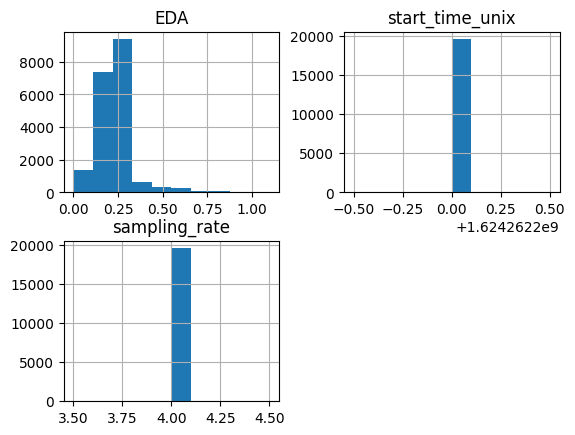

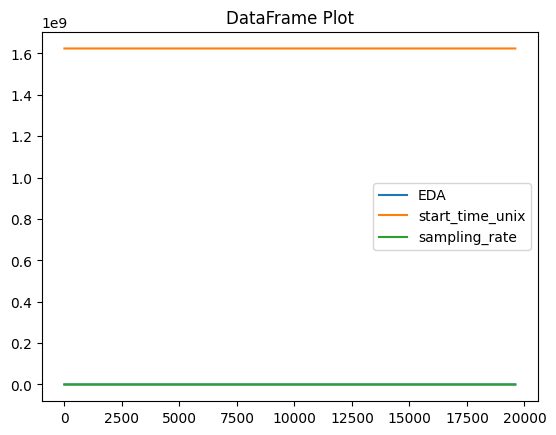

In [56]:
eda_df.hist()
eda_df.plot(title="DataFrame Plot")

# 3. Preprocessing

### 3.1.Merge DataFrames


In [ ]:
combined_df = pd.merge(hr_df, eda_df, on='start_time_unix', how='inner')
combined_df['mean_EDA'] = eda_df['EDA'].rolling(window=100).mean()
combined_df = combined_df.dropna()
combined_df.head(100)

# 4: Data Splitting and Scaling

In [58]:
X = combined_df.drop(['sampling_rate_y', 'start_time_unix'], axis=1)
y = combined_df['sampling_rate_y'] 



In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5: Model Training

### 5.1 Using a Random Forest Classifier

In [60]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [61]:
y_pred_rf = rf_model.predict(X_test)

In [62]:
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

         4.0       1.00      1.00      1.00      3901

    accuracy                           1.00      3901
   macro avg       1.00      1.00      1.00      3901
weighted avg       1.00      1.00      1.00      3901



### 5.2. Using a Neural Network (MLP)

In [63]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0000e+00 - loss: -422.7798 - val_accuracy: 0.0000e+00 - val_loss: -7630.1987
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -16952.2148 - val_accuracy: 0.0000e+00 - val_loss: -63445.8203
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: -91731.2266 - val_accuracy: 0.0000e+00 - val_loss: -205095.3125
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -259960.0938 - val_accuracy: 0.0000e+00 - val_loss: -455357.5312
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: -542186.6875 - val_accuracy: 0.0000e+00 - val_loss: -830499.8750
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: -951337.3125 - val_accuracy: 0.0000e+00 - val_loss: -1341339.3750
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -1496472.0000 - val_accuracy: 0.0000

In [65]:
y_pred_mlp = mlp_model.predict(X_test)
y_pred_mlp = (y_pred_mlp > 0.5).astype(int)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [66]:
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))

MLP Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       0.0
         4.0       0.00      0.00      0.00    3901.0

    accuracy                           0.00    3901.0
   macro avg       0.00      0.00      0.00    3901.0
weighted avg       0.00      0.00      0.00    3901.0



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

# 6: Visualization

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


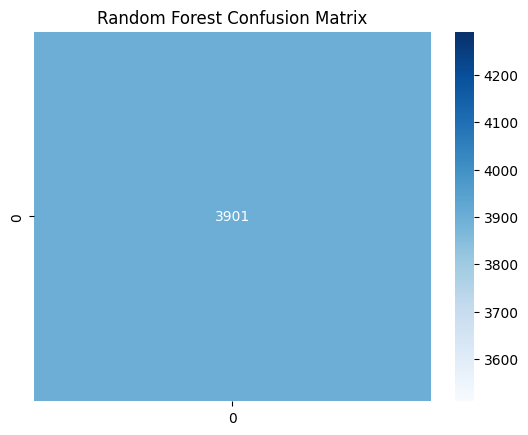

In [67]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()